In [1]:
from reactor_components.perform_faceswap import FaceSwapScript
from reactor_components.utils import download_ckpts
from PIL import Image
from omegaconf import OmegaConf


class FaceSwapper:

    def __init__(self, config_path: str) -> None:
        self.cfg = OmegaConf.load(config_path)
        download_ckpts(self.cfg)
        self.script = FaceSwapScript()

    def do_swap(self, input_image: Image.Image, source_image: Image.Image) -> Image.Image:
        swapped = self.script.process(source_img=source_image, input_img=input_image, cfg=self.cfg)
        return swapped

def inference_reactor(pipe, source_image, face_image):
    out_image = pipe.do_swap(source_image, face_image)
    return out_image


pipe = FaceSwapper('/home/jovyan/dzinovev/2/reactor_components/reactor_config.yml')

ModuleNotFoundError: No module named 'reactor_components'

In [9]:
%cd ..

/home/jovyan/dzinovev/2


In [4]:
!pip install wget

DEPRECATION: Loading egg at /home/jovyan/.mlspace/envs/.env_cover/lib/python3.11/site-packages/src-0.1.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Using cached wget-3.2-py3-none-any.whl


In [31]:
%cd /home/jovyan/dzinovev/2
import torch
from diffusers import StableDiffusionXLPipeline, AutoencoderKL, EulerAncestralDiscreteScheduler
from controlnet_union import ControlNetModel_Union
from pipeline_controlnet_union_sd_xl import StableDiffusionXLControlNetUnionPipeline
from transformers import CLIPVisionModelWithProjection
from inference import inference_sdxl, inference_reactor, Processors
import os
import copy
import sys

device = torch.device("cuda:0")

# faceswap_pipe = FaceSwapper('./reactor_components/reactor_config.yml')

# Load shared model components
scheduler = EulerAncestralDiscreteScheduler.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", subfolder="scheduler"
)

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)

controlnet_model = ControlNetModel_Union.from_pretrained(
    "xinsir/controlnet-union-sdxl-1.0", torch_dtype=torch.float16, use_safetensors=True
)

image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
).to(dtype=torch.float16)

# Load base SDXL pipeline
pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    scheduler=scheduler,
    image_encoder=image_encoder,
)

# Load controlnet pipeline using the shared UNet
controlnet_pipe = StableDiffusionXLControlNetUnionPipeline(
    vae=pipe.vae,
    text_encoder=pipe.text_encoder,
    text_encoder_2=pipe.text_encoder_2,
    tokenizer=pipe.tokenizer,
    tokenizer_2=pipe.tokenizer_2,
    unet=pipe.unet,  # Shared UNet
    controlnet=controlnet_model,
    scheduler=scheduler,
    image_encoder=pipe.image_encoder,
)

pipe = pipe.to(device, dtype=torch.float16)
controlnet_pipe = controlnet_pipe.to(device, dtype=torch.float16)

/home/jovyan/dzinovev/2


Loading pipeline components...: 100%|██████████| 7/7 [00:07<00:00,  1.14s/it]


In [32]:
from PIL import Image
import base64
from io import BytesIO

def encode_image_to_base64(image: Image.Image) -> str:
    """
    Encodes a PIL image to a base64 string.

    Args:
        image (Image.Image): The PIL image to encode.

    Returns:
        str: The base64 encoded string of the image.
    """
    buffer = BytesIO()
    image.save(buffer, format='PNG')  # Save as PNG or any desired format
    buffer.seek(0)
    encoded_string = base64.b64encode(buffer.getvalue()).decode('utf-8')
    return encoded_string

def decode_base64_to_image(encoded_string: str) -> Image.Image:
    """
    Decodes a base64 string back to a PIL image.

    Args:
        encoded_string (str): The base64 encoded string of the image.

    Returns:
        Image.Image: The decoded PIL image.
    """
    image_data = base64.b64decode(encoded_string)
    buffer = BytesIO(image_data)
    image = Image.open(buffer)
    return image

In [33]:
import numpy as np
from controlnet_aux import (
    OpenposeDetector, 
    MidasDetector, 
    ZoeDetector, 
    LineartDetector, 
    HEDdetector, 
    MLSDdetector, 
    NormalBaeDetector, 
    SamDetector, 
    PidiNetDetector,  
)
import random
import cv2
import torch

class Processors: 
    def __init__(self, device="cuda", cache_dir="./weights"): 
        self.processors = self._init_processors(device, cache_dir)

    def nms(self, x, t, s):
        x = cv2.GaussianBlur(x.astype(np.float32), (0, 0), s)
    
        f1 = np.array([[0, 0, 0], [1, 1, 1], [0, 0, 0]], dtype=np.uint8)
        f2 = np.array([[0, 1, 0], [0, 1, 0], [0, 1, 0]], dtype=np.uint8)
        f3 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=np.uint8)
        f4 = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]], dtype=np.uint8)
    
        y = np.zeros_like(x)
    
        for f in [f1, f2, f3, f4]:
            np.putmask(y, cv2.dilate(x, kernel=f) == x, x)
    
        z = np.zeros_like(y, dtype=np.uint8)
        z[y > t] = 255
        return z
    
    def HWC3(self, x):
        assert x.dtype == np.uint8
        if x.ndim == 2:
            x = x[:, :, None]
        assert x.ndim == 3
        H, W, C = x.shape
        assert C == 1 or C == 3 or C == 4
        if C == 3:
            return x
        if C == 1:
            return np.concatenate([x, x, x], axis=2)
        if C == 4:
            color = x[:, :, 0:3].astype(np.float32)
            alpha = x[:, :, 3:4].astype(np.float32) / 255.0
            y = color * alpha + 255.0 * (1.0 - alpha)
            y = y.clip(0, 255).astype(np.uint8)
            return y
        
    def processor_scribble(self, source_img:np.ndarray, processor_hed, output_type='cv2',): 
        controlnet_img = processor_hed(source_img, scribble=False)
        controlnet_img.save("a hed detect path for an image")
    
        controlnet_img = np.array(controlnet_img)
        controlnet_img = nms(controlnet_img, 127, 3)
        controlnet_img = cv2.GaussianBlur(controlnet_img, (0, 0), 3)
    
        random_val = int(round(random.uniform(0.01, 0.10), 2) * 255)
        controlnet_img[controlnet_img > random_val] = 255
        controlnet_img[controlnet_img < 255] = 0
        controlnet_img = Image.fromarray(controlnet_img) if output_type == 'pil' else controlnet_img
        return controlnet_img

    def processor_softedge(self, source_img, processor_hed): 
        controlnet_img = processor_hed(source_img, scribble=False)
    
        controlnet_img = np.array(controlnet_img)
        controlnet_img = nms(controlnet_img, 127, 3)
        controlnet_img = cv2.GaussianBlur(controlnet_img, (0, 0), 3)
    
        # higher threshold, thiner line
        random_val = int(round(random.uniform(0.01, 0.10), 2) * 255)
        controlnet_img[controlnet_img > random_val] = 255
        controlnet_img[controlnet_img < 255] = 0
        controlnet_img = Image.fromarray(controlnet_img)
        return controlnet_img
        
    def processor_canny(self, source_img:np.ndarray, output_type='pil'): 
        controlnet_img = cv2.Canny(source_img, 100, 200)
        controlnet_img = self.HWC3(controlnet_img)    
        controlnet_img = Image.fromarray(controlnet_img) if output_type == 'pil' else controlnet_img
        return controlnet_img
    
    def _init_processors(self, device, cache_dir): 
        # 0 -- openpose
        # 1 -- depth
        # 2 -- hed/pidi/scribble/ted
        # 3 -- canny/lineart/anime_lineart/mlsd
        # 4 -- normal
        # 5 -- segment

        openpose_processors = {
            "openpose": OpenposeDetector.from_pretrained('lllyasviel/ControlNet', cache_dir=cache_dir),
        }
        depth_processors = {
            'zoe': ZoeDetector.from_pretrained("lllyasviel/Annotators", cache_dir=cache_dir),
            'midas': MidasDetector.from_pretrained("lllyasviel/Annotators", cache_dir=cache_dir),
        }
        sketch_processors = {
            'pidi': PidiNetDetector.from_pretrained('lllyasviel/Annotators', cache_dir=cache_dir).to(device), 
            'hed': HEDdetector.from_pretrained('lllyasviel/Annotators', cache_dir=cache_dir).to(device), 
        }
        canny_processors = {
            'canny': self.processor_canny, 
        }
        normal_processors = {
            "normal": NormalBaeDetector.from_pretrained('lllyasviel/Annotators', cache_dir=cache_dir).to(device),
        }
        segment_processors = {
            "sam": SamDetector.from_pretrained(
                "ybelkada/segment-anything", 
                subfolder="checkpoints",
                cache_dir=cache_dir,
            )
        }
        return {
            "openpose": openpose_processors,  
            "depth": depth_processors, 
            "hed": sketch_processors, 
            "edges": canny_processors, 
            "normal": normal_processors, 
            "segment": segment_processors, 
        }

    
    def __call__(self, image:np.ndarray, processor: str = 'canny'): 
        conditions = []
        selected_processor = random.choice(
            list(self.processors[processor].values())
        )
        condition_image = selected_processor(image, output_type='pil')
        return condition_image
        

In [34]:
condition_images.keys()

dict_keys(['openpose', 'depth', 'hed', 'edges', 'normal', 'segment'])

In [35]:
condition_types = []
processor_pipe = Processors()
condition_scale = 0.25
condition_images = {
    "openpose": 0,  
    "depth": 0, 
    # "hed": 0, 
    "edges": 0, 
    "normal": 0, 
    # "segment": 0
}
width = 1024
height = 1024
for condition_type in condition_images.keys():
    # print(f"preparing {condition_type}")
    condition_image = Image.open('/home/jovyan/dzinovev/2/IMG_9236.webp')
    condition_image = condition_image.resize((width, height))
    condition_image = np.array(condition_image)
    condition_image = processor_pipe(condition_image, condition_type)
    condition_image = condition_image.resize((width, height))
    condition_images[condition_type] = condition_image
    condition_types.append(condition_type)

image_list = list(condition_images.values())
union_control_type = torch.Tensor([bool(condition_images[ct]) for ct in condition_images])

Loading base model ()...Done.
Removing last two layers (global_pool & classifier).


In [36]:
controlnet_pipe.load_ip_adapter(
        "h94/IP-Adapter",
        subfolder="sdxl_models",
        weight_name=["ip-adapter-plus-face_sdxl_vit-h.bin", "ip-adapter-plus_sdxl_vit-h.bin"],
        image_encoder_folder=None,
    )

In [23]:
condition_image.size

(1024, 1024)

In [37]:

ip_scales = [0.2, 0.8]
ip_images = [Image.open('/home/jovyan/dzinovev/2/11.webp'), Image.open('/home/jovyan/dzinovev/2/IMG_9236.webp')]


controlnet_pipe.set_ip_adapter_scale(ip_scales)

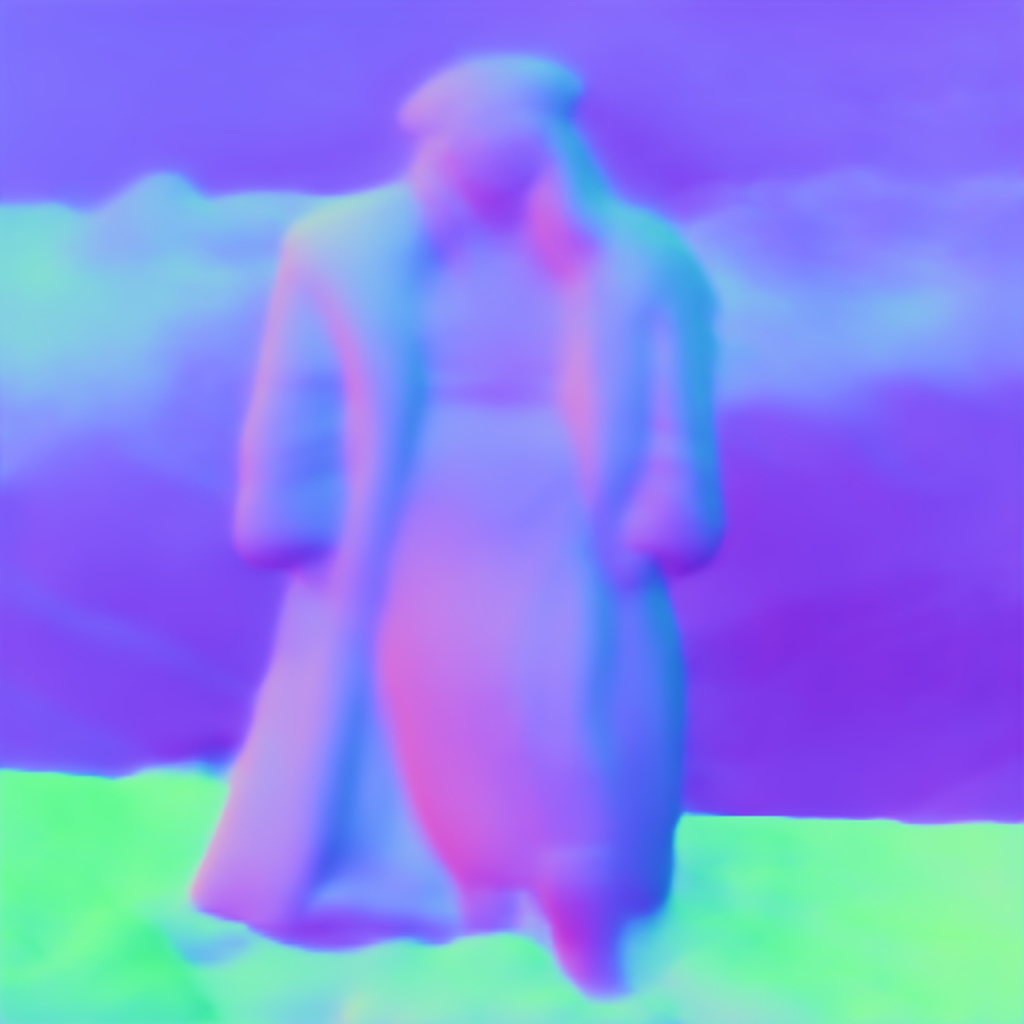

In [38]:
condition_image

In [ ]:
Image.open('/home/jovyan/dzinovev/2/11.webp')

In [39]:
seed = 42
generator = torch.Generator('cuda').manual_seed(seed) if seed else torch.Generator('cuda')
num_images_per_prompt = 1
num_steps = 50

images = controlnet_pipe(
                prompt=['woman in mountains, 4K, ultra detailed'] * num_images_per_prompt,
                image_list=image_list,
                negative_prompt=[''] * num_images_per_prompt,
                generator=generator,
                width=1024,
                height=1024,
                num_inference_steps=num_steps,
                target_size=(width, height),
                original_size=(width, height),
                controlnet_conditioning_scale=condition_scale,
                union_control=True,
                guidance_scale=10.5,
                union_control_type=torch.Tensor([int(bool(image)) for image in image_list]),
                ip_adapter_image=ip_images,
            ).images

  0%|          | 0/50 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x1024 and 1536x1280)

In [ ]:
images[0]

In [1]:
!pip install --upgrade diffusers

In [19]:
face_image = Image.open('/home/jovyan/dzinovev/2/11.webp')
source_image = Image.open('/home/jovyan/dzinovev/2/test_target/Снимок экрана 2025-02-08 204404.png')
swapped_image = inference_reactor(pipe, source_image, face_image)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./weights/reactor/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./weights/reactor/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./weights/reactor/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./weights/reactor/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./weights/reactor/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Applied providers

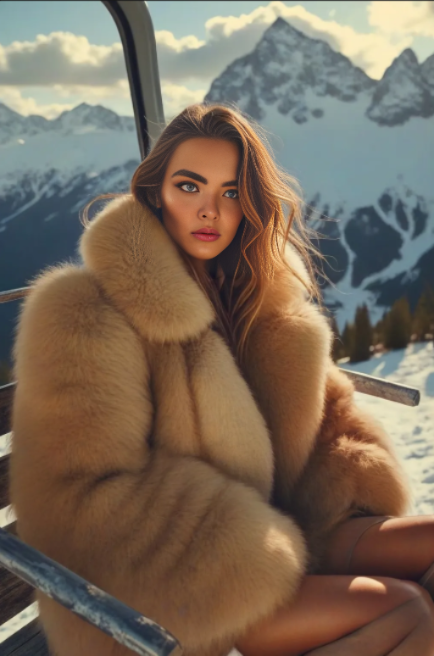

In [21]:
swapped_image

In [13]:
swapped_image.save('/home/jovyan/dzinovev/2/test_target/reactor.jpg')

In [3]:
%pwd

'/home/jovyan/.local/share/Trash/files/CodeFormer'

In [5]:
%cd /home/jovyan/dzinovev/2
!git clone https://github.com/sczhou/CodeFormer.git
%cd CodeFormer

# Set up the environment
# Install python dependencies
!pip install -r requirements.txt
# Install basicsr
!python basicsr/setup.py develop

# Download the pre-trained model
!python scripts/download_pretrained_models.py facelib
!python scripts/download_pretrained_models.py CodeFormer

# Visualization function
import cv2
import matplotlib.pyplot as plt
def display(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1) 
  plt.title('Input', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('CodeFormer', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)
def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

/home/jovyan/dzinovev/2
Cloning into 'CodeFormer'...
remote: Enumerating objects: 614, done.
remote: Counting objects: 100% (297/297), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 614 (delta 208), reused 183 (delta 183), pack-reused 317 (from 3)
Receiving objects: 100% (614/614), 17.31 MiB | 23.51 MiB/s, done.
Resolving deltas: 100% (296/296), done.
/home/jovyan/dzinovev/2/CodeFormer
DEPRECATION: Loading egg at /home/jovyan/.mlspace/envs/.env_cover/lib/python3.11/site-packages/src-0.1.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /home/jovyan/.mlspace/envs/.env_cover/lib/python3.11/site-packages/gdown-5.2.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://gith

In [17]:
CODEFORMER_FIDELITY = 0.8 #@param {type:"slider", min:0, max:1, step:0.01}
#@markdown `BACKGROUND_ENHANCE`: Enhance background image with Real-ESRGAN<br>
BACKGROUND_ENHANCE = False #@param {type:"boolean"}
#@markdown `FACE_UPSAMPLE`: Upsample restored faces for high-resolution AI-created images<br>
FACE_UPSAMPLE = True #@param {type:"boolean"}
if BACKGROUND_ENHANCE:
  if FACE_UPSAMPLE:
    !python inference_codeformer.py -w $CODEFORMER_FIDELITY --input_path /home/jovyan/dzinovev/2/test_target --bg_upsampler realesrgan --face_upsample
  else:
    !python inference_codeformer.py -w $CODEFORMER_FIDELITY --input_path /home/jovyan/dzinovev/2/test_target --bg_upsampler realesrgan
else:
  !python inference_codeformer.py -w $CODEFORMER_FIDELITY --input_path /home/jovyan/dzinovev/2/test_target

Face detection model: retinaface_resnet50
Background upsampling: False, Face upsampling: False
[1/4] Processing: reactor.jpg
	detect 1 faces
[2/4] Processing: very-good-quality-yes-smiling-beautiful-girl-shows-okay-sign-ok-gesture-nod-approval-agree-like-something-praise-excellent-choice-pleased-by-perfect-service-white-background_176420-45028.jpg
	detect 1 faces
[3/4] Processing: Снимок экрана 2025-02-08 183408.png
	detect 1 faces
[4/4] Processing: Снимок экрана 2025-02-08 204404.png
	detect 1 faces

All results are saved in results/test_target_0.8


In [18]:
%cd ..


/home/jovyan/dzinovev/2
